# 4. Use DCGAN to build a generator for a face image dataset

Celebrity Face Dataset

The face dataset I used is from here : https://www.kaggle.com/tannys26/face-extracted-from-celeba-dataset

The dataset consists of cropped faces that were extracted by CelebA Dataset. The backgrounds from the dataset have been removed and contain the faces which are saved in the form of an array in an .npz file.

### Set up GANs

In [1]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [3]:
def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

### Discriminator

In [4]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [5]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

Here's a function for a single step for the discriminator:

In [6]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

And here's a function for a single step of the generator:

In [7]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

## Load the dataset

First I need to load the npz file and get the numpy array inside

arr_0
(50000, 80, 80, 3)


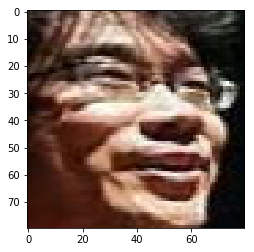

In [8]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

npz = np.load('img_celeba.npz')
lst = npz.files

for item in lst:
    print(item)
    data = npz[item]
    break

print(data.shape)

plt.imshow(data[9])
plt.show()

### Reshape the data and convert to PIL image

(50000, 80, 80, 3)
(80, 80, 3)


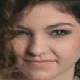

In [6]:
import PIL
from IPython.display import Image
%matplotlib inline 


data = np.transpose(data,(0,3,1,2))
print(data.shape)

first = data[2]
print(first.shape)

pil = PIL.Image.fromarray(first.astype('uint8'), 'RGB')
pil

### Function for converting all data into png files

In [10]:
def create_PIL_img(data):
    for i in range(data.shape[0]):
        new_im = PIL.Image.fromarray(data[i])
        new_im.save(f"celeb-PIL/all/celeb{i}.png")

In [11]:
# from PIL import Image
# create_PIL_img(data)

### Load the data into data loader

In [ ]:
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset

compose = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])

ds = torchvision.datasets.ImageFolder(root='celeb-PIL', transform=compose)

batch_size = 256
data_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

num_batches = len(data_loader)
print(num_batches)

### Networks

In [13]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

The generator is using transpose convolutions with batch normalization:

In [14]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)


Let's create a generator and discriminator and initialize their weights: 

In [15]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

### Optimizers

Next, we set up the optimizers and loss function.

In [16]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 50

### Training

As before, we'll generate a fixed set of noise samples to see the evolution of the
generator over time then start training:

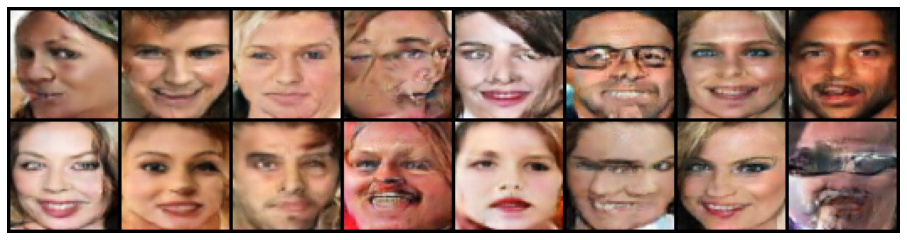

Epoch: [49/50], Batch Num: [100/196]
Discriminator Loss: 0.3211, Generator Loss: 2.6237
D(x): 0.8741, D(G(z)): 0.1544


In [17]:
num_test_samples = 16
test_noise = noise(num_test_samples)

logger = Logger(model_name='celebGAN', data_name='celeb')

for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(data_loader):

        # Train Discriminator
        
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Log error and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)


## RESULTS
After training for 50 EPOCHS we can see the generated faces from the test_noise as above.

We can see that more than half of the faces looks like real people faces

From the discriminator predicted value are as the following : 

        D(x): 0.8741, D(G(z)): 0.1544
        
which mean that the discriminator can still distinguish between the real and fake data quite well.

It implies that we may be able to train more EPOCHs or adapt the architecture for the model to converge faster.

# Conclusion

In this lab, we learn 2 basic GANs architecture.

First, the Vanilla GAN which consist of fully connected neural network for both the Generator and the Discriminator. We use the Vanilla GAN to generate the MNIST dataset and the 'S' dataset.

Secondly, we learn Deep Convolutional GANs which consisted of many convolution and deconvolution layers. In the lab, we use them to generate CIFAR and Celeb face dataset.

I also learn how to overwrite the torch dataset class to generate data from a custom distribution. This lab is also the first time I am able to see the log in tensorboard and I find it very convenient!

